<p> <center> <h1>Mars Exploration: Informed and Uninformed Search </h1> </center> </p>

<br><br>

An important source of information for the exploration of Mars are the images obtained with orbiters that are continuously sending information about the surface of our neighboring planet. A large number of high-resolution images captured by various satellites with instruments capable of measuring the depth and other characteristics of the Martian soil are available on the HiRISE page. These data helped determine the place where the Perseverance Rover landed on the last mission carried out by NASA on the red planet.

The following figure is the 3D representation of a small part of the surface of Mars. The axes represent distances in meters, and the colors indicate the deepest (in red) and highest (in light yellow) parts. The deepest part of the surface shown is taken as level 0. This data is located on the HiRISE site.

<div style="text-align: center;">
  <div style="display: inline-block;">
    <img src="mars_3D.png" width="600"/>
  </div>
</div>

The information shown above can be represented in an image like the one shown below. The color of each pixel in the image represents the height at that position. Sections in gray represent areas where there is no satellite information.

<div style="text-align: center;">
  <div style="display: inline-block;">
    <img src="mars_2D.png" height="500"/>
  </div>
</div>

Data on the HiRISE site is available in IMG files with topographic information. In the original files, the above surface has dimensions of 7557 pixels wide and 18143 pixels high. Each pixel represents an area of 1.0017 meters x 1.0017 meters. These data are not RGB colors, they are height values, and the image displayed is known as a false color image, since it is artificially constructed by assigning a color to each pixel according to some dimension or measurement (in this case, depth values or height). These images are called height maps. Values in gray have a height value of -1, and represent areas where there is no valid information.

The displayed surface data file is provided in the file named 'mars_map.IMG'. Because the data file size is around 1Gb, the original image is scaled to a smaller size. With this, the images shown have dimensions of 756 x 1814, and each pixel represents an area of 10.0174 x 10.0174.

<br>

<p><h4> <b>Problem 1: Testing search algorithms</b> </h4></p>

For the height map presented in this activity, use at least four search algorithms to determine a possible navigation route from position x = 2850 y = 6400 to point x = 3150 y = 6800.

To determine possible routes, consider the following:

- The Explorer Rover can move from one pixel to another contiguous pixel on the map in any direction, but only if the difference in height between the current position and the next position is less than 0.25 meters (the program must handle this value as a parameter that can be easily modified).
- Map pixels with a height of -1 are invalid and the Rover cannot move towards them.

For this problem, it is necessary to indicate the distance traveled by the Rover. Also, answer the following questions:

1. What algorithms managed to find a valid route?
2. Is it necessary to use informed searches for this case?
3. Which heuristic function was suitable for this problem?

In [1]:
# Import the required libraries
import copy
import heapq
import numpy as np
from collections import deque
from skimage.transform import downscale_local_mean
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import plotly.graph_objects as px
import warnings

In [2]:
# Function to preprocess and visualize the height map of the landscape
def process_height_map(input_file, output_file):
    # Open the data file
    data_file = open(input_file, "rb")

    # Parse header information
    endHeader = False
    while not endHeader:
        line = data_file.readline().rstrip().lower()

        sep_line = line.split(b'=')
        
        if len(sep_line) == 2:
            itemName = sep_line[0].rstrip().lstrip()
            itemValue = sep_line[1].rstrip().lstrip()

            # Extract information from header
            if itemName == b'valid_maximum':
                maxV = float(itemValue)
            elif itemName == b'valid_minimum':
                minV = float(itemValue)
            elif itemName == b'lines':
                n_rows = int(itemValue)
            elif itemName == b'line_samples':
                n_columns = int(itemValue)
            elif itemName == b'map_scale':
                scale_str = itemValue.split()
                if len(scale_str) > 1:
                    scale = float(scale_str[0])

        elif line == b'end':
            endHeader = True
            # Move to the start of actual data
            char = 0
            while char == 0 or char == 32:
                char = data_file.read(1)[0] 
            pos = data_file.seek(-1, 1)     

    # Read and preprocess image data
    image_size = n_rows * n_columns
    data = data_file.read(4 * image_size)
    image_data = np.frombuffer(data, dtype=np.dtype('f'))
    image_data = image_data.reshape((n_rows, n_columns)).astype('float64')
    image_data -= minV
    image_data[image_data < -10000] = -1

    # Subsample the image
    sub_rate = round(10 / scale) 
    image_data = downscale_local_mean(image_data, (sub_rate, sub_rate))
    image_data[image_data < 0] = -1

    print('Sub-sampling:', sub_rate)
    new_scale = scale * sub_rate
    print('New scale:', new_scale, 'meters/pixel')

    # Save preprocessed map
    np.save(output_file, image_data)

    # Load preprocessed height map
    image_data = np.load(output_file)
    
    return image_data, scale, new_scale, maxV, minV, n_rows, n_columns


# Function to plot the map in 3D using Plotly
def plot3D(image_data, new_scale, maxV, minV, n_rows, n_columns):
    # Plot 3D surface
    x = np.arange(image_data.shape[1]) * new_scale
    y = np.arange(image_data.shape[0]) * new_scale
    X, Y = np.meshgrid(x, y)

    # Plot 3D surface using Plotly
    fig = px.Figure(data = px.Surface(x=X, y=Y, z=np.flipud(image_data), colorscale='hot', cmin=0, 
                                    lighting=dict(ambient=0.0, diffuse=0.8, fresnel=0.02, roughness=0.4, specular=0.2), 
                                    lightposition=dict(x=0, y=n_rows/2, z=2*maxV)),
                    layout = px.Layout(scene_aspectmode='manual', 
                                        scene_aspectratio=dict(x=1, y=n_rows/n_columns, z=max((maxV-minV)/x.max(), 0.2)), 
                                        scene_zaxis_range=[0, maxV-minV]))
    
    fig.show()


# Function to plot the map in 2D using Matplotlib
def plot2D(image_data, n_rows, n_columns, scale, new_scale, start=None, target=None, path=None, ax=None):   
    # Plot surface image
    cmap = copy.copy(plt.cm.get_cmap('autumn'))
    cmap.set_under(color='black')   

    ls = LightSource(315, 45)
    rgb = ls.shade(image_data, cmap=cmap, vmin=0, vmax=image_data.max(), vert_exag=2, blend_mode='hsv')
    
    # Use matplotlib.colormaps.get_cmap(obj) instead of plt.cm.get_cmap('autumn')
    #cmap = copy.copy(plt.colormaps.get_cmap('autumn'))
    
    im = ax.imshow(rgb, cmap=cmap, vmin=0, vmax=image_data.max(), 
                   extent=[0, scale * n_columns, 0, scale * n_rows], 
                   interpolation='nearest', origin='upper')
    
    # Plot initial point and path
    if start and target and path:
        start_point = ax.scatter(start[1] * new_scale, n_rows - start[0] * new_scale, color='blue', label='Start Point', marker='o', s=40)
        end_point = ax.scatter(target[1] * new_scale, n_rows - target[0] * new_scale, color='green', label='End Point', marker='o', s=40)

        path_x, path_y = zip(*path)
        path_line = ax.plot(np.array(path_y) * new_scale, n_rows - np.array(path_x) * new_scale , color='deeppink', label='Path', linewidth=2)

        # Add legends
        ax.legend(handles=[start_point, end_point, path_line[0]], loc='best', fontsize=6)

    # Add color bar for height and set title and labels
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height (m)')
    ax.set_title('Mars surface')
    ax.set_xlabel('X (m)', fontstyle='italic')
    ax.set_ylabel('Y (m)', fontstyle='italic')


# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Define a class to represent a state in the navigation problem
class NavigationState:
    def __init__(self, x, y, target, parent=None, cost=0):
        self.x = x
        self.y = y
        self.parent = parent
        self.cost = cost
        self.target = target  # Store the target position
        self.heuristic = self.heuristicCost(target)  # Precompute heuristic cost
    
    # Calculate the estimated cost of reaching the target position from this position using a heuristic
    def heuristicCost(self, target):
        # Manhattan distance between current and target positions
        return abs(self.x - target[0]) + abs(self.y - target[1])
        
    # Define state comparison based on estimated cost plus actual cost
    def __lt__(self, other):
        return self.cost + self.heuristic < other.cost + other.heuristic

    # Function to get the successors of a given state
    def getSuccessors(self, height_map, max_height_diff, target):
        successors = []
        
        # Define the possible actions including diagonal movements
        actions = [
            (self.x - 1, self.y),      # Move Up
            (self.x + 1, self.y),      # Move Down
            (self.x, self.y - 1),      # Move Left
            (self.x, self.y + 1),      # Move Right
            (self.x - 1, self.y - 1),  # Move Up-Left (Diagonal)
            (self.x - 1, self.y + 1),  # Move Up-Right (Diagonal)
            (self.x + 1, self.y - 1),  # Move Down-Left (Diagonal)
            (self.x + 1, self.y + 1)   # Move Down-Right (Diagonal)
        ]

        # Iterate over all possible actions
        for new_x, new_y in actions:
            # Check if the action is valid (new position is within the map boundaries)
            if 0 <= new_x < height_map.shape[0] and 0 <= new_y < height_map.shape[1]:
                # Check if the new position is valid (not -1) and height difference is within limit
                if height_map[new_x, new_y] != -1 and height_map[new_x, new_y] - height_map[self.x, self.y] <= max_height_diff:
                    successors.append(NavigationState(new_x, new_y, target, self))

        return successors

In [4]:
# Function to recover the solution path from the target state to the initial state
def getSolutionPath(state):
    path = []
    while state:
        path.append((state.x, state.y))
        state = state.parent
    return list(reversed(path))


# Function to calculate row and column from given coordinate
def calculate_row_col(x, y, new_scale, n_rows):
    row = n_rows - (y / new_scale)
    column = x / new_scale
    return (round(row), round(column))


# A* Informed Search algorithm
def astar_search(height_map, start, target, max_height_diff):
    # Define initial state and target state
    initial_state = NavigationState(start[0], start[1], target)
    target_state = NavigationState(target[0], target[1], target)

    # Initialize the A* search algorithm
    open_list = []
    closed_set = set()

    # Add the initial state to the open list
    heapq.heappush(open_list, initial_state)

    # Perform A* search until reaching the target state
    while open_list:
        current_state = heapq.heappop(open_list)

        # Check if the target state has been reached
        if (current_state.x, current_state.y) == (target_state.x, target_state.y):
            solution_path = getSolutionPath(current_state)
            return solution_path

        # Mark current state as visited
        closed_set.add((current_state.x, current_state.y))

        # Get the successors of the current state
        successors = current_state.getSuccessors(height_map, max_height_diff, target)

        # Add successors to the open list if they have not been visited
        for successor in successors:
            if (successor.x, successor.y) not in closed_set:
                successor.cost = current_state.cost + 1
                heapq.heappush(open_list, successor)

    # Return None if no solution is found
    return None, None


# Breadth-First Search algorithm
def bfs(height_map, start, target, max_height_diff):
    # Initialize queue with starting state
    queue = deque([NavigationState(start[0], start[1], target)]) 

    # Set to keep track of visited states
    visited = set()

    while queue:
        current_state = queue.popleft()  # Pop the leftmost node from the queue

        # Check if the current state is the goal state
        if (current_state.x, current_state.y) == target:
            solution_path = getSolutionPath(current_state)
            return solution_path

        # Mark the current state as visited
        visited.add((current_state.x, current_state.y))

        # Get the successors of the current state
        successors = current_state.getSuccessors(height_map, max_height_diff, target)

        # Add successors to the queue if they have not been visited
        for successor in successors:
            if (successor.x, successor.y) not in visited:
                queue.append(successor)

    # If the goal state is not found
    return None


# Depth-First Search algorithm
def dfs(height_map, start, target, max_height_diff):
    # Initialize stack with starting state
    stack = [NavigationState(start[0], start[1], target)]

    # Set to keep track of visited states
    visited = set()

    while stack:
        current_state = stack.pop()  # Pop the topmost node from the stack

        # Check if the current state is the goal state
        if (current_state.x, current_state.y) == target:
            solution_path = getSolutionPath(current_state)
            return solution_path

        # Mark the current state as visited
        visited.add((current_state.x, current_state.y))

        # Get the successors of the current state
        successors = current_state.getSuccessors(height_map, max_height_diff, target)

        # Add successors to the stack if they have not been visited
        for successor in successors:
            if (successor.x, successor.y) not in visited:
                stack.append(successor)
                visited.add((successor.x, successor.y))

    # If the goal state is not found
    return None


# Bidirectional Breadth-First Search algorithm
def bidirectional_bfs(height_map, start, target, max_height_diff):
    # Initialize queues for forward and backward search
    forward_queue = deque([NavigationState(start[0], start[1], target)])
    backward_queue = deque([NavigationState(target[0], target[1], start)])

    # Sets to keep track of visited states for forward and backward search
    forward_visited = set()
    backward_visited = set()

    while forward_queue and backward_queue:
        # Forward search
        forward_current_state = forward_queue.popleft()  # Pop the leftmost node from the forward queue
        if (forward_current_state.x, forward_current_state.y) in backward_visited:
            # If the forward state intersects with the backward search, a path is found
            forward_path = getSolutionPath(forward_current_state)
            backward_path = getSolutionPath(backward_visited[(forward_current_state.x, forward_current_state.y)])
            return forward_path + list(reversed(backward_path))

        # Mark the current state as visited in forward search
        forward_visited.add((forward_current_state.x, forward_current_state.y))

        # Get the successors of the current state in forward search
        forward_successors = forward_current_state.getSuccessors(height_map, max_height_diff, target)

        # Add successors to the forward queue if they have not been visited
        for forward_successor in forward_successors:
            if (forward_successor.x, forward_successor.y) not in forward_visited:
                forward_queue.append(forward_successor)

        # Backward search
        backward_current_state = backward_queue.popleft()  # Pop the leftmost node from the backward queue
        if (backward_current_state.x, backward_current_state.y) in forward_visited:
            # If the backward state intersects with the forward search, a path is found
            backward_path = getSolutionPath(backward_current_state)
            forward_path = getSolutionPath(forward_visited[(backward_current_state.x, backward_current_state.y)])
            return forward_path + list(reversed(backward_path))

        # Mark the current state as visited in backward search
        backward_visited.add((backward_current_state.x, backward_current_state.y))

        # Get the successors of the current state in backward search
        backward_successors = backward_current_state.getSuccessors(height_map, max_height_diff, start)

        # Add successors to the backward queue if they have not been visited
        for backward_successor in backward_successors:
            if (backward_successor.x, backward_successor.y) not in backward_visited:
                backward_queue.append(backward_successor)

    # If no path is found
    return None


# Uniform Cost Search (UCS) algorithm
def ucs(height_map, start, target, max_height_diff):
    # Initialize priority queue with starting state
    priority_queue = [(0, NavigationState(start[0], start[1], target))]

    # Set to keep track of visited states
    visited = set()

    while priority_queue:
        # Pop the state with the lowest cost from the priority queue
        current_cost, current_state = heapq.heappop(priority_queue)

        # Check if the current state is the goal state
        if (current_state.x, current_state.y) == target:
            solution_path = getSolutionPath(current_state)
            return solution_path

        # Mark the current state as visited
        visited.add((current_state.x, current_state.y))

        # Get the successors of the current state
        successors = current_state.getSuccessors(height_map, max_height_diff, target)

        # Add successors to the priority queue if they have not been visited
        for successor in successors:
            if (successor.x, successor.y) not in visited:
                heapq.heappush(priority_queue, (successor.cost, successor))

    # If the goal state is not found
    return None, None


def visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, target, ax=None, three_D=False):
    # Create a copy of the original map
    path_map = np.copy(mars_map)

    # Mark the path positions on the map
    for x, y in path:
        path_map[x, y] = 0 # Mark the path position with the lowest height 
        # path_map[x, y] = mars_map.max()  # Mark the path position with the maximum height 
    
    # Plot the path map
    if three_D:
        plot3D(path_map, new_scale, maxV, minV, n_rows, n_columns)
    else:
        plot2D(mars_map, n_rows, n_columns, scale, new_scale, start, target, path, ax)

Sub-sampling: 10
New scale: 10.017330185711 meters/pixel

Optimal path found using A* Search Algorithm. Distance traveled: 401 meters.

Optimal path found using DFS Search Algorithm. Distance traveled: 74088 meters.

Optimal path found using UCS Search Algorithm. Distance traveled: 401 meters.


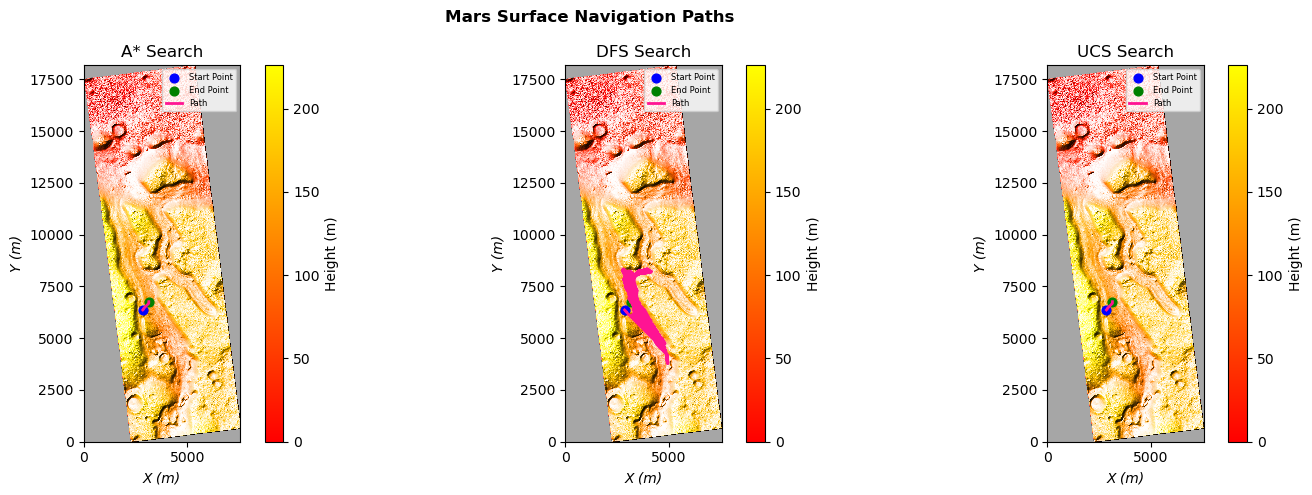

In [5]:
# Main function
def main():
    input_file = "mars_map.img"
    output_file = "mars_map.npy"

    # Process and visualize height map
    image_data, scale, new_scale, maxV, minV, n_rows, n_columns = process_height_map(input_file, output_file)

    # Load height map and calculate row and column from a given coordinate
    mars_map = np.load('mars_map.npy')
    
    # Define start and end points
    start = calculate_row_col(2850, 6400, new_scale, mars_map.shape[0])
    target = calculate_row_col(3150, 6800, new_scale, mars_map.shape[0])

    # Define maximum height difference allowed
    max_height_diff = 0.25  # meters
           
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Find and visualize paths using different algorithms
    algorithms = [astar_search, dfs, ucs]
    algorithm_names = ['A* Search', 'DFS Search', 'UCS Search']
    
    for i, (algorithm, name) in enumerate(zip(algorithms, algorithm_names)):
        path = algorithm(mars_map, start, target, max_height_diff)
        if path != (None, None):
            print(f"\nOptimal path found using {name} Algorithm. Distance traveled: {round((len(path) - 1) * new_scale)} meters.")        
            visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, target, ax=axs[i])
            axs[i].set_title(name)
        else:
            print(f"\nNo valid navigation path found using {name}.")

    # Adjust layout and display the plot
    fig.suptitle('Mars Surface Navigation Paths', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Visualize the best algorithm path in 3D
    #path = astar_search(mars_map, start, target, max_height_diff)
    #visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, target, three_D=True)
      
        
if __name__ == "__main__":
    main()

1. Which algorithms managed to find a valid path?
   - Among the five algorithms implemented, including A*, BFS, DFS, Bidirectional, UCS, only three of them were successful in finding a valid path due to the complexity and size of the search space: A* (A-star), DFS (Depth-First Search), and UCS (Uniform Cost Search). These algorithms were able to navigate through the Mars surface map and discover an effective route from the starting point to the target point. The other two algorithms, BFS (Breadth-First Search) and Bidirectional Search, did not manage to find a valid path within a reasonable time frame.

2. Is it necessary to use informed searches for this case?
   - Informed searches, such as A* which utilizes a heuristic function, proved effective in finding a valid path within a reasonable time frame. However, it's not strictly necessary to use informed searches for this case. The success of DFS and UCS in finding valid paths indicates that uninformed search algorithms can also be viable options, especially if the problem space is not overly complex. 

3. Which heuristic function proved suitable for this problem?
   - For the A* algorithm, the Manhattan distance heuristic function was employed. This heuristic calculates the estimated cost of reaching the target position from the current position based on the Manhattan distance, which is the sum of the absolute differences in the x and y coordinates between the current and target positions. In this particular problem of navigating the Mars surface, where movements are constrained to adjacent pixels, the Manhattan distance heuristic provided a reasonable estimate of the remaining cost to reach the target.

<br>

<p><h4> <b>Problem 2: Performance of search algorithms for short and long routes</b> </h4></p>

Select one of the search algorithms tested in the previous section of this phase of the project, and with it determine navigation routes for at least two pairs of coordinates that you select yourselves, in such a way that the starting point and the objective are not more than 500 meters. Do the same, but with at least two pairs that have a distance between start and finish of more than 1000 meters and less than 5000 meters. Finally, try pairs of coordinates that are greater than 10,000 meters away.

Answer the following questions:

1. In which cases is the algorithm capable of solving the problem in an acceptable time?
2. In cases where the algorithm does not find a result, what actions could be taken to help the algorithm solve the problem?

Sub-sampling: 10
New scale: 10.017330185711 meters/pixel

Distance between (1950, 8300) and (2150, 8500): 283 meters
Distance between (4300, 15000) and (4100, 15000): 200 meters
Distance between (2250, 100) and (3350, 4500): 4535 meters
Distance between (2850, 6400) and (5800, 6600): 2957 meters
Distance between (1010, 16000) and (2200, 8050): 8039 meters
Distance between (7000, 1500) and (100, 17500): 17424 meters

Optimal path found using A* Search Algorithm. Distance traveled: 200 meters.

Optimal path found using A* Search Algorithm. Distance traveled: 401 meters.

No valid navigation path found using A* Search.


KeyboardInterrupt: 

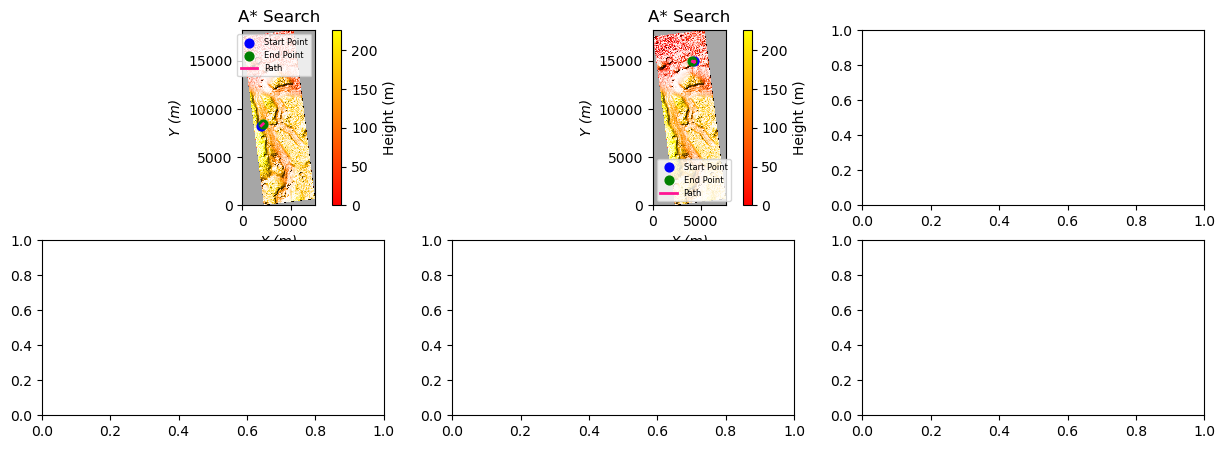

In [6]:
# Main function
def main():
    input_file = "mars_map.img"
    output_file = "mars_map.npy"

    # Process and visualize height map
    image_data, scale, new_scale, maxV, minV, n_rows, n_columns = process_height_map(input_file, output_file)

    # Load height map and calculate row and column from a given coordinate
    mars_map = np.load('mars_map.npy')
    
    # Define maximum height difference allowed
    max_height_diff = 0.25  # meters
    
    # Define different start and end points
    starts = [(1950, 8300), (4300, 15000), (2250, 100), (2850, 6400), (1010, 16000), (7000, 1500)]
    targets = [(2150, 8500), (4100, 15000), (3350, 4500), (5800, 6600), (2200, 8050), (100, 17500)]
    
    # Display Euclidian distance between each start and end point
    print()
    for start, target in zip(starts, targets):
        print(f"Distance between {start} and {target}: {round(np.sqrt((start[0] - target[0])**2 + (start[1] - target[1])**2))} meters")
    
    # Transform and combine the points into a single list
    starts = [calculate_row_col(x, y, new_scale, mars_map.shape[0]) for x,y in starts]
    targets = [calculate_row_col(x, y, new_scale, mars_map.shape[0]) for x,y in targets]
    combined_points = [(start, target) for start, target in zip(starts, targets)]
           
    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    
    # Find and visualize paths using A* algorithm   
    for i, (start, target) in enumerate(combined_points):
        path = astar_search(mars_map, start, target, max_height_diff)
        if path != (None,None):
            print(f"\nOptimal path found using A* Search Algorithm. Distance traveled: {round((len(path) - 1) * new_scale)} meters.")        
            visualize_path_on_map(mars_map, path, new_scale, maxV, minV, n_rows, n_columns, scale, start, target, ax=axs[i // 3, i % 3])
            axs[i // 3, i % 3].set_title('A* Search')
        else:
            print(f"\nNo valid navigation path found using A* Search.")

    # Adjust layout and display the plot
    fig.suptitle('Mars Surface Navigation Paths', fontweight='bold')
    plt.tight_layout()
    plt.show()
      
        
if __name__ == "__main__":
    main()

1. In which cases is the algorithm capable of solving the problem in an acceptable time?
    - The A* algorithm appears to be the most suitable choice for this problem. However, it was only successful in resolving 2 out of the 6 points provided, specifically the first 2 points with an Euclidean distance between them of less than 500 meters.
    - Moreover, it accurately determined that the third point had no solution due to the maximum height restriction imposed on the rover's climbing capability.
    - The remaining points failed to execute completely due to the excessive time it was taking, indicating that beyond the inability to find a solution (which is uncertain if it would change with a more powerful computing setup), we concluded that the search algorithm becomes inefficient beyond this point for computing equipment with limited resources like ours.
    - Therefore, the algorithm is capable of solving the problem in an acceptable time when the distance between the start and target points is relatively small, such as within 500 meters. In these cases, A* algorithm efficiently explores the search space and finds optimal or near-optimal paths without exceeding the time constraints. This is evident in scenarios where the rover needs to navigate short distances, enabling the algorithm to quickly converge to a solution. 

2. In cases where the algorithm does not find a result, what actions could be taken to help the algorithm solve the problem?
    - One approach could involve optimizing the algorithm's parameters, such as adjusting the heuristic function or exploring alternative search strategies. Additionally, considering the computational resources available, improving the efficiency of the algorithm's implementation or utilizing parallel computing techniques may help overcome performance limitations.
    - Employing advanced pruning techniques such as symmetry breaking, subgoal graphs, or path symmetry detection can help reduce redundant exploration of the search space, thereby improving the algorithm's efficiency. These techniques aim to eliminate unnecessary branches of the search tree, focusing computational efforts on more promising regions of the space.
    - Moreover, relaxing certain constraints, such as the maximum height threshold of 0.25 meters for the rover's traversal, could enhance the algorithm's ability to find solutions in exploring the Martian surface effectively and scenarios with more challenging terrain features
 
In conclusion, while A* algorithm demonstrates effectiveness in solving navigation problems over short distances, its performance may degrade when faced with longer and more complex paths, particularly due to computational constraints and search space limitations. By adjusting algorithmic parameters, refining heuristic functions, and implementing optimization strategies, the algorithm's capabilities can be enhanced, enabling it to tackle a broader range of scenarios efficiently.